<h1 align="center">Volume 2: The Fourier Transform.</h1>

    Caelan Osman
    Math 345 Sec 1
    December 1, 2020

<h2 align="center">Part 1: The Discrete Fourier Transform</h2>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
import IPython
import scipy.fftpack
import time
import math
import scipy.signal
import imageio

In [2]:
plt.rcParams["figure.dpi"] = 300             # Fix plot quality.
plt.rcParams["figure.figsize"] = (12,3)      # Change plot size / aspect (you may adjust this).

In [20]:
class SoundWave(object):
    """A class for working with digital audio signals."""

    # Problem 1.1
    def __init__(self, rate, samples):
        """Set the SoundWave class attributes.

        Parameters:
            rate (int): The sample rate of the sound.
            samples ((n,) ndarray): NumPy array of samples.
        """
        #set attributes
        self.sample_rate = rate 
        self.samples = samples
        #number of seconds /length of sample
        self.num_seconds = len( self.samples ) / self.sample_rate 
        num_points = self.num_seconds / len( self.samples )
        self.seconds = np.arange( 0, self.num_seconds, num_points )

    # Problems 1.1 and 1.7
    def plot(self, frequencies=False, suptitle=None):
        """Plot the graph of the sound wave (time versus amplitude)."""
        #num_points = self.num_seconds / len( self.samples )
        #np.arange( 0, self.num_seconds, num_points )
        if frequencies:
            fig, axs = plt.subplots(1,2, constrained_layout=True)
            ax = axs[0]
            ax.plot(self.seconds , self.samples, 'b')
            ax.set_xlabel('Time(seconds)')
            ax.set_ylabel('Samples')
            ax.set_ylim([-32768, 32767])
            ax.set_title('Sound')
            
            ax = axs[1]
            mag = np.abs(scipy.fftpack.fft(self.samples))
            f = np.array([k * self.sample_rate / len(self.samples) for k in range(len(self.samples))])
            ax.plot(f[:len(self.samples)//2], mag[:len(self.samples)//2])
            ax.set_xlabel('Frequencey (Hz)')
            ax.set_ylabel('Magnitude')
            ax.set_title('DFT')
            if suptitle is None:
                plt.show()
            else:
                fig.suptitle(suptitle)
                plt.show()
            
        else:
            #plot seconds against sample
            plt.plot( self.seconds , self.samples, 'b' )
            plt.ylim( [ -32768, 32767 ] )
            plt.xlabel('Time (seconds)')
            plt.ylabel('Samples')
            plt.title('Sound')
            plt.show()
        
    # Problem 1.2
    def export(self, filename, force=False):
        """Generate a wav file from the sample rate and samples. 
        If the array of samples is not of type np.int16, scale it before exporting.

        Parameters:
            filename (str): The name of the wav file to export the sound to.
        """
        
        if self.samples.dtype != 'int16' or force:
            #scale and get real part
            scaled = (self.samples / np.max(abs(self.samples))) * 32767
            #export
            wavfile.write(filename, self.sample_rate, np.int16(scaled.real))
        else:
            #export real part
            wavfile.write(filename, self.sample_rate, self.samples.real)
            
         
    # Problem 1.4
    def __add__(self, other):
        """Combine the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to add
                to the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the combined samples.

        Raises:
            ValueError: if the two sample arrays are not the same length.
        """
        
        if len(self.samples) != len(other.samples):
            raise ValueError('The sample arrays are not the same length')
        
        return SoundWave(self.sample_rate, self.samples + other.samples)
        
        
        
    # Problem 1.4
    def __rshift__(self, other):
        """Concatentate the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to concatenate
                to the samples contained in this object.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        
        if self.sample_rate != other.sample_rate:
            raise ValueError('The sample rates are not equal')
            
        return SoundWave(self.sample_rate, np.concatenate((self.samples, other.samples)))
            
    
    # Problem 2.1
    def __mul__(self, other):
        """Convolve the samples from two SoundWave objects using circular convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.sample_rate != other.sample_rate:
            raise ValueError('The sample rates are not equal')
            
        self_len = len(self.samples)
        other_len = len(other.samples)
        #if the lenghts are the same
        if self_len == other_len:
            #get fft
            f_hat = scipy.fftpack.fft(self.samples).real
            g_hat = scipy.fftpack.fft(other.samples).real
            #compute hadamard product
            hadamard = f_hat * g_hat
            #compute ifft to get convolution
            convolution = scipy.fftpack.ifft(hadamard).real
            #return new sound wave object
            return SoundWave(self.sample_rate, convolution)
        
        #if the current object is greater in length than other
        elif self_len > other_len:
            diff = self_len - other_len
            zero = np.zeros(diff)
            #append zeros to other object, then repeat as above
            g = np.concatenate((other.samples, zero))
            f_hat = scipy.fftpack.fft(self.samples).real
            g_hat = scipy.fftpack.fft(g).real
            hadamard = f_hat * g_hat
            convolution = scipy.fftpack.ifft(hadamard).real
            return SoundWave(self.sample_rate, convolution)
        
        #if the current object is less in length than other
        else:
            diff = other_len - self_len
            zero = np.zeros(diff)
            #append zeros to current object, then repeat as above
            f = np.concatenate((self.samples, zero))
            f_hat = scipy.fftpack.fft(f).real
            g_hat = scipy.fftpack.fft(other.samples).real
            hadamard = f_hat * g_hat
            convolution = scipy.fftpack.ifft(hadamard).real
            return SoundWave(self.sample_rate, convolution)
        
    # Problem 2.2
    def __pow__(self, other):
        """Convolve the samples from two SoundWave objects using linear convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.sample_rate != other.sample_rate:
            raise ValueError('The sample rates are not equal')
        #get n, m
        n = len(self.samples)
        m = len(other.samples)
        #compute a
        a = math.ceil(np.log2(n + m- 1))
        #pad A, B with zeros
        self_zeros = np.zeros(2**a - n)
        other_zeros = np.zeros(2**a - m)
        A = np.concatenate((self.samples, self_zeros))
        B = np.concatenate((other.samples, other_zeros))
        
        A_hat = scipy.fftpack.fft(A).real
        B_hat = scipy.fftpack.fft(B).real
        #compute hadamard product
        hadamard = A_hat * B_hat
        #compute ifft to get convolution
        convolution = scipy.fftpack.ifft(hadamard).real
        #return new sound wave object
        return SoundWave(self.sample_rate, convolution[:m+n-1])
    
    # Problem 2.4
    def clean(self, low_freq, high_freq):
        """Remove a range of frequencies from the samples using the DFT. 

        Parameters:
            low_freq (float): Lower bound of the frequency range to zero out.
            high_freq (float): Higher boound of the frequency range to zero out.
        """
        n = len(self.samples)
        klow = (n * low_freq) // self.sample_rate
        khigh = (n * high_freq) // self.sample_rate
        DFT = scipy.fftpack.fft(self.samples)
        
        DFT[klow:khigh] = 0
        DFT[n-khigh:n-klow]=0
        self.samples = scipy.fftpack.ifft(DFT).real

### Problem 1.1

- Implement `SoundWave.__init__()`.
- Implement `SoundWave.plot()`.
- Use the `scipy.io.wavfile.read()` and the `SoundWave` class to plot `tada.wav`.

int16
14781
-16383


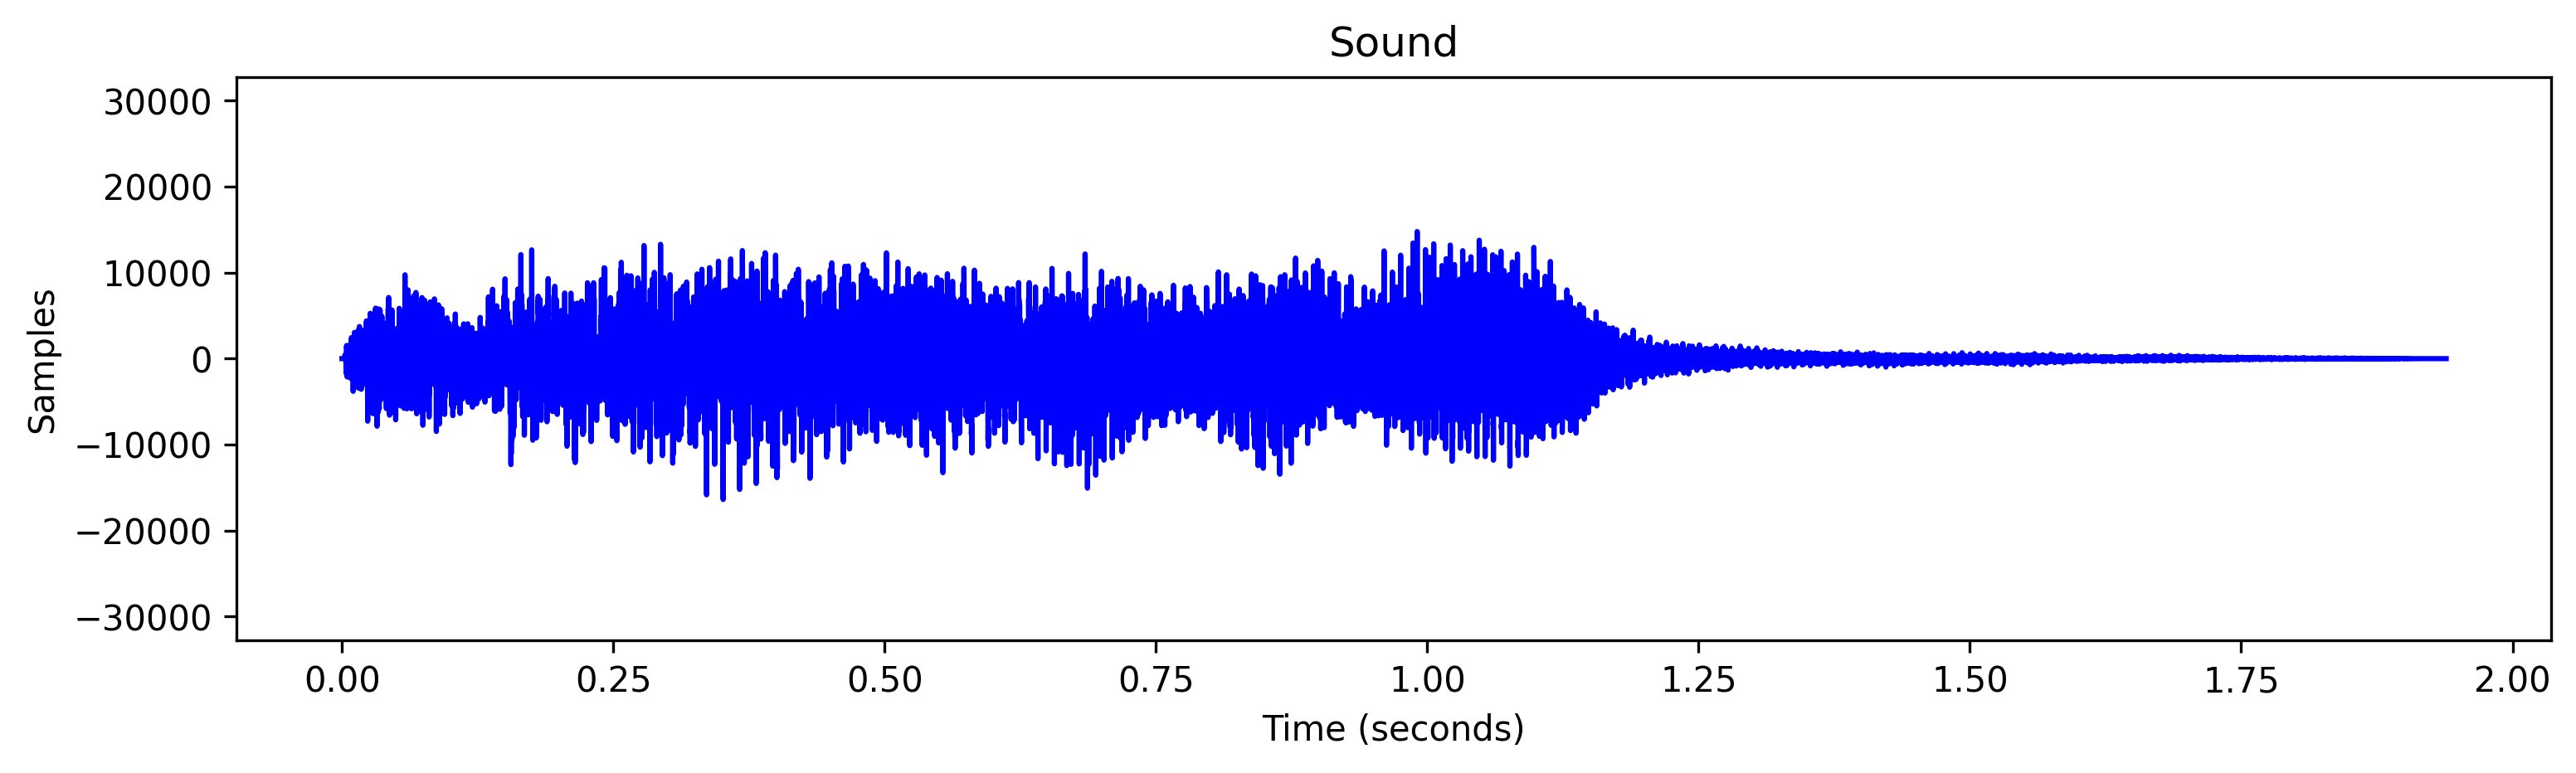

In [22]:
rate, samples = wavfile.read('tada.wav')
wave = SoundWave(rate, samples)
wave.plot()

### Problem 1.2

- Implement `SoundWave.export()`.
- Use the `export()` method to create two new files containing the same sound as `tada.wav`: one without scaling, and one with scaling (use `force=True`).
- Use `IPython.display.Audio()` to embed the original and new versions of `tada.wav` in the notebook.

In [19]:
rate, samples = wavfile.read( 'tada.wav' )
wave = SoundWave( rate, samples )
wave.export('tada_scale.wav', force=True)
wave.export('tada_no_scale.wav')

In [6]:
print('Original:')
IPython.display.Audio(filename='tada.wav')

Original:


In [7]:
print('Scaled:')
IPython.display.Audio(filename='tada_scale.wav')

Scaled:


In [8]:
print('Not Scaled:')
IPython.display.Audio(filename='tada_no_scale.wav')

Not Scaled:


### Problem 1.3

- Implement `generate_note()`.
- Use `generate_note()` to create an A tone that lasts for two seconds. Embed it in the notebook.

In [9]:
def generate_note(frequency, duration):
    """Generate an instance of the SoundWave class corresponding to 
    the desired soundwave. Uses sample rate of 44100 Hz.
    
    Parameters:
        frequency (float): The frequency of the desired sound.
        duration (float): The length of the desired sound in seconds.
    
    Returns:
        sound (SoundWave): An instance of the SoundWave class.
    """
    r = 44100
    num_samples = r * duration
    domain_points = np.arange(0, duration, 1 / r)
    def func( x ):
        return np.sin(2 * np.pi * x * frequency)
    sample_points = func(domain_points)
    
    return SoundWave(r, sample_points)
    

In [10]:
A_note = generate_note(440, 2)
A_note.export('A_tone.wav')
print('A Tone:')
IPython.display.Audio(filename='A_tone.wav')

A Tone:


### Problem 1.4

- Implement `SoundWave.__add__()`.
- Generate a three-second A minor chord (A, C, and E) and embed it in the notebook.
- Implement `SoundWave.__rshift__()`.
- Generate the arpeggio A$\,\rightarrow\,$C$\,\rightarrow\,$E, where each tone lasts one second, and embed it in the notebook.

In [11]:
A_note = generate_note(440, 3)
C_note = generate_note(523.25, 3)
E_note = generate_note(659.25, 3)
A_minor = A_note + C_note + E_note
A_minor.export('A_minor.wav')
print('A-Minor Tone:')
IPython.display.Audio(filename='A_minor.wav')

A-Minor Tone:


In [12]:
A_note = generate_note(440, 1)
C_note = generate_note(523.25, 1)
E_note = generate_note(659.25, 1)
Arpeggio = A_note >> C_note >> E_note
Arpeggio.export('Arpeggio.wav')
print('Arpeggio:')
IPython.display.Audio(filename='Arpeggio.wav')

Arpeggio:


### Problem 1.5

- Implement `simple_dft()` with the formula $c=F_nf$, where $F_n$ is the n-dimensional DFT matrix.
- Use `np.allclose()` to check that `simple_dft()` and `scipy.fftpack.fft()` give the same result (after scaling).

In [13]:
def simple_dft(samples):
    """Compute the DFT of an array of samples.

    Parameters:
        samples ((n,) ndarray): an array of samples.
    
    Returns:
        ((n,) ndarray): The DFT of the given array.
    """
    
    n = len(samples)
    m = np.arange(n).reshape(n,1)
    W = np.exp((-2j * np.pi / n) * m @ m.T)
    
    return W @ samples / n
    
    

In [14]:
n = 5
a = np.random.random(n)
print(np.allclose(simple_dft(a), (1/n) * scipy.fftpack.fft(a)))

True


### Problem 1.6

- Implement `simple_fft()`.
- Generate an array of $8192$ random samples and take its DFT using `simple_dft()`, `simple_fft()`, and `scipy.fftpack.fft()`.
Print the runtimes of each computation.
- Use `np.allclose()` to check that `simple_fft()` and `scipy.fftpack.fft()` give the same result (after scaling).

In [15]:
def simple_fft(samples, threshold=1):
    """Compute the DFT using the FFT algorithm.
    
    Parameters:
        samples ((n,) ndarray): an array of samples.
        threshold (int): when a subarray of samples has fewer
            elements than this integer, use simple_dft() to
            compute the DFT of that subarray.
    
    Returns:
        ((n,) ndarray): The DFT of the given array.
        
    """
    def split(g):
        n = g.size
        if n <= threshold:
            return n * simple_dft(g)
        else:
            even = split(g[::2])
            odd = split(g[1::2])
            z = np.complex128(np.zeros(n))
            for k in range(n):
                z[ k ] = np.exp(-2j * np.pi * k / n)
            m = n // 2
            first_part = even + z[:m] * odd
            second_part = even + z[m:] * odd 
        return np.concatenate([first_part, second_part])
    return split(samples) / len(samples)
 
    

In [16]:
a = np.random.random(8192)
simple_dft_start = time.time()
simple_dft(a)
simple_dft_end = time.time()
b = simple_fft(a)
simple_fft_end = time.time()
c = scipy.fftpack.fft(a)
scipy_fft_end = time.time()
print('Simple DFT: ', simple_dft_end - simple_dft_start)
print('Simple FFT: ', simple_fft_end - simple_dft_end)
print('SciPy DFT: ', scipy_fft_end - simple_fft_end)
print(np.allclose(b, c/8192))

Simple DFT:  2.61617112159729
Simple FFT:  0.4377124309539795
SciPy DFT:  0.00025725364685058594
True


### Problem 1.7

- Modify `SoundWave.plot()` so that it accepts a boolean. When the boolean is `True`, take the DFT of the stored samples and plot (in a new subplot) the frequencies present on the $x$-axis and the magnituds of those frequences on the $y$-axis. Only the display the first half of the plot, and adjust the $x$-axis so that it correctly shows the frequencies in Hertz.
- Display the plot of the DFT of an A tone.
- Display the plot of the DFT of an A minor chord.

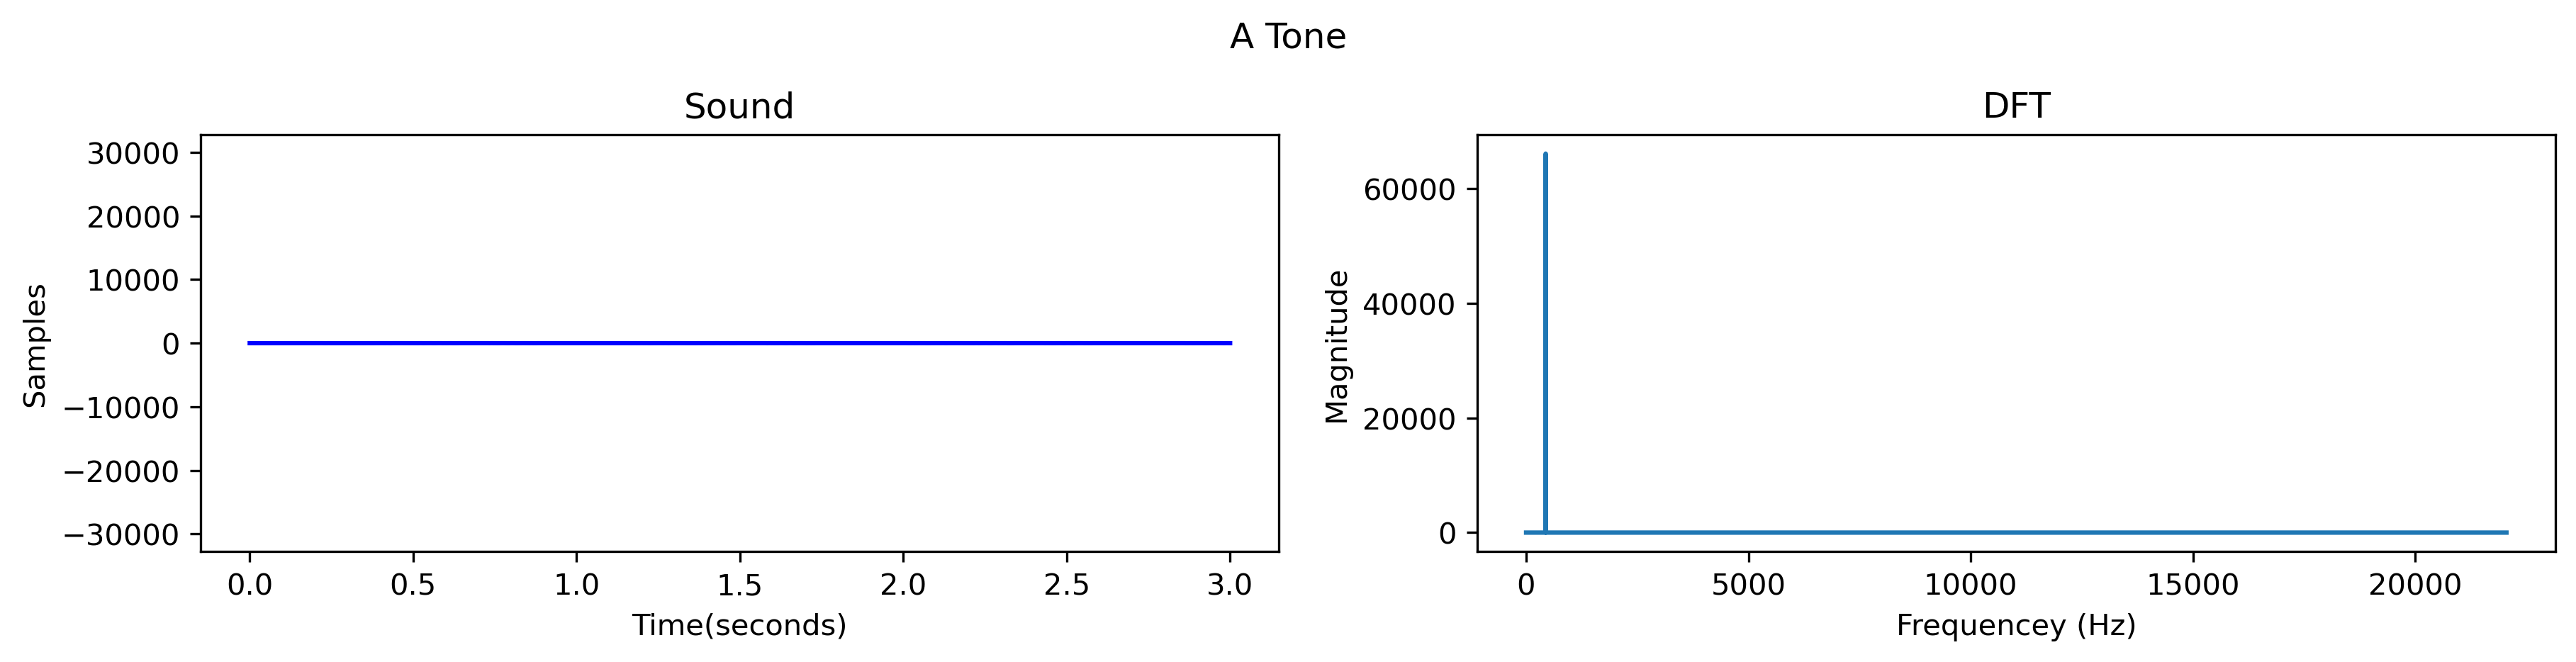

In [17]:
A_note = generate_note(440, 3)
C_note = generate_note(523.25, 3)
E_note = generate_note(659.25, 3)
A_minor = A_note + C_note + E_note
A_note.plot(True, 'A Tone')

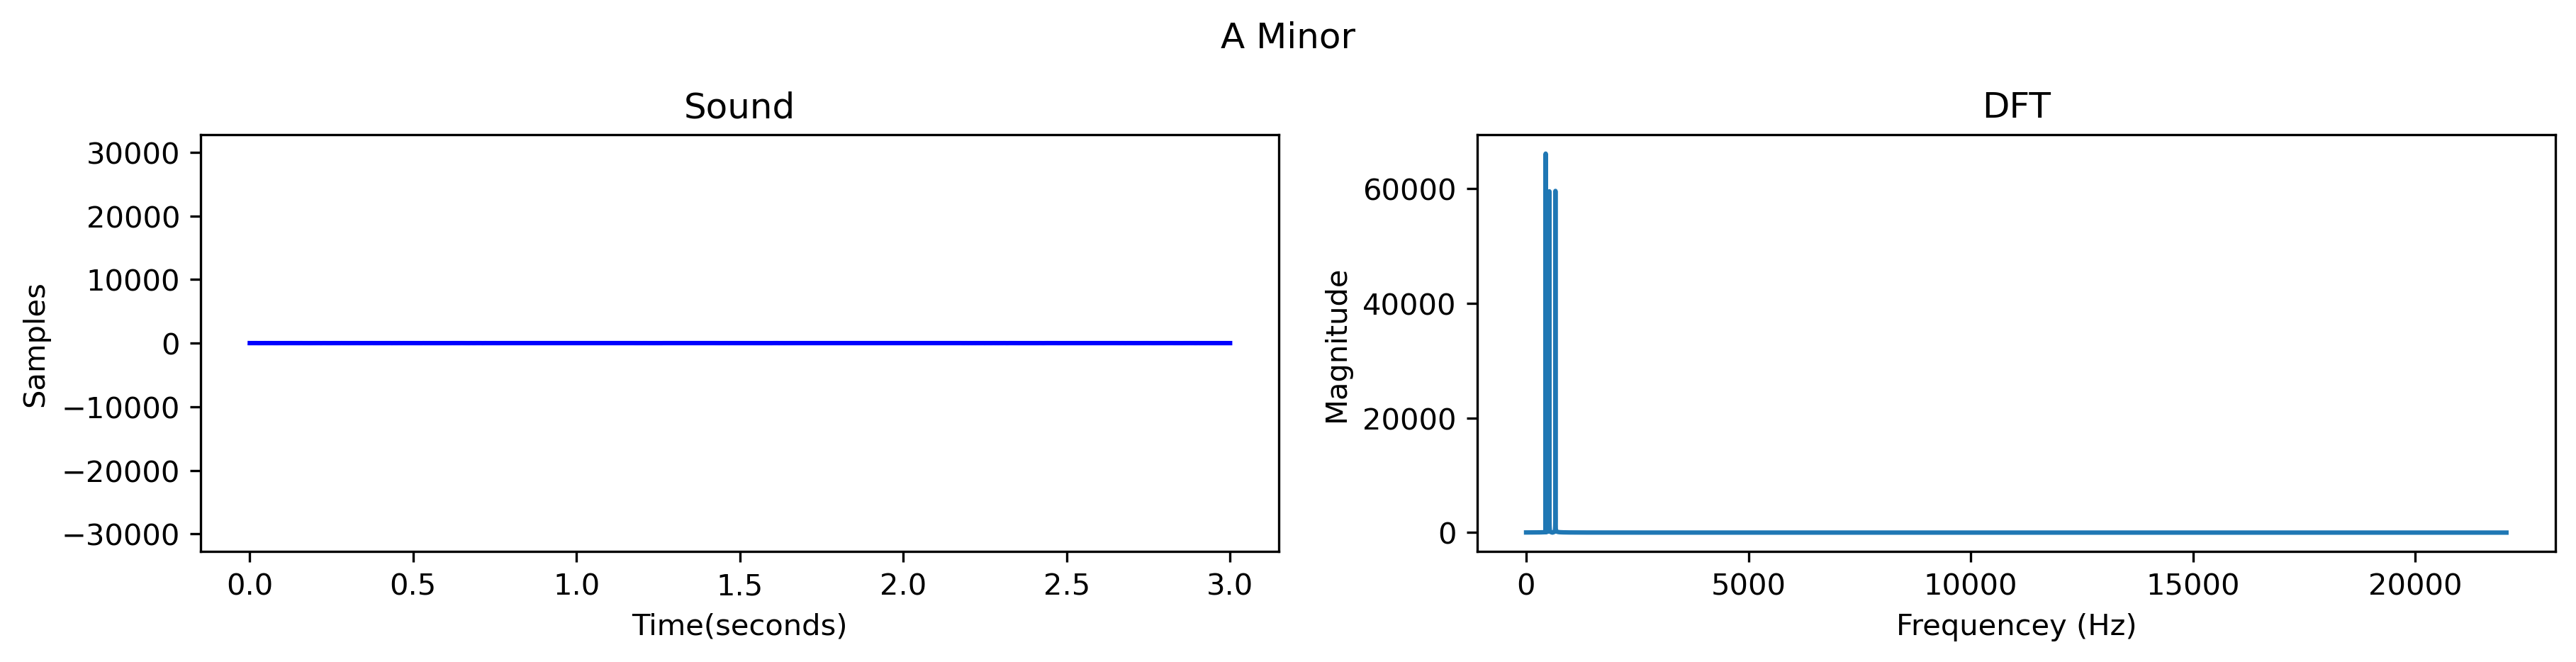

In [18]:
A_minor.plot(True, 'A Minor')

### Problem 1.8

Use the DFT to determine the individual notes that are present in `mystery_chord.wav`.

In [19]:
rate, samples = wavfile.read('mystery_chord.wav')
mystery = SoundWave(rate, samples)
mag = np.abs(scipy.fftpack.fft(mystery.samples)[:len(mystery.samples) // 2])
frequencies = np.array([k * mystery.sample_rate / len(mystery.samples) for k in range(len(mystery.samples))])[:len(mystery.samples)//2]
sort = np.argsort(mag)
frequency_1 = frequencies[sort[-1]]
frequency_2 = frequencies[sort[-2]]
frequency_3 = frequencies[sort[-3]]
frequency_4 = frequencies[sort[-4]]


In [20]:
print('1st: A', frequency_1)
print('2n: G', frequency_2)
print('3rd: C', frequency_3)
print('4th: D', frequency_4)

1st: A 440.0
2n: G 784.0
3rd: C 523.25
4th: D 587.5


The notes are...
A, G, C, D

<h2 align="center">Part 2: Convolution and Filtering.</h2>

### Problem 2.1

- Implement `SoundWave.__mul__()` for circular convolution.
- Generate 2 seconds of white noise at the same sample rate as `tada.wav`.
- Compute the circular convolution of `tada.wav` and the white noise. Embed the result in the notebook.
- Append the circular convolution to itself and embed the result in the notebook.

In [21]:
rate, samples = wavfile.read('tada.wav')
tada = SoundWave(rate, samples)
white_noise_sample = np.random.randint(-32767, 32767, rate*2, dtype=np.int16)
white_noise = SoundWave(rate, white_noise_sample)
con = tada * white_noise
appended = con >> con

In [22]:
appended.export('convolved.wav')
print('Convolved:')
IPython.display.Audio(filename='convolved.wav')

Convolved:


### Problem 2.2

- Implement `SoundWave.__pow__()` for linear convolution.
- Time the linear convolution of `CGC.wav` and `GCG.wav` using `SoundWave.__pow__()` and `scipy.signal.fftconvolve()`.
- Embed the two original sounds and their convolutions in the notebook. Check that the convolutions with `SoundWave.__pow__()` and `scipy.signal.fftconvolve()` sound the same.

In [23]:
rate_g, samples_g = wavfile.read('GCG.wav')
G_1 = SoundWave(rate_g, samples_g)
G_2 = SoundWave(rate_g, samples_g)

In [24]:
class_start = time.time()
G_1 ** G_2
class_end = time.time()
print('Class Method Time: ', class_end - class_start)

Class Method Time:  0.10814857482910156


In [25]:
scipy_start = time.time()
h = scipy.signal.fftconvolve(G_1, G_2)
scipy_end = time.time()
print('Scipy Method Time: ', scipy_end-scipy_start)

Scipy Method Time:  0.016733646392822266


### Problem 2.3

Use `SoundWave.__pow__()` or `scipy.signal.fftconvolve()` to compute the linear convolution of `chopin.wav` and `balloon.wav`.
Embed the two original sounds and their convolution in the notebook.

In [26]:
rate_c, samples_c = wavfile.read('chopin.wav')
chop = SoundWave(rate_c, samples_c)
print('Chopin')
IPython.display.Audio(filename='chopin.wav')

Chopin


In [27]:
rate_b, samples_b = wavfile.read('balloon.wav')
ball = SoundWave(rate_b, samples_b)
print('Balloon')
IPython.display.Audio(filename='balloon.wav')

Balloon


In [29]:
chop_ball = SoundWave(rate_c, scipy.signal.fftconvolve(samples_c, samples_b))
chop_ball.export('chop_ball.wav')
print('Linear Convolution')
IPython.display.Audio(filename='chop_ball.wav')

Linear Convolution


In [33]:
chop_ball_2 = ball ** chop
IPython.display.Audio(data=chop_ball.samples, rate=chop_ball.sample_rate)

### Problem 2.4

- Implement `SoundWave.clean()`.
- Clean `noisy1.wav` by filtering out frequencies from $1250$-$2600$ Hz. Embed the original and the cleaned versions in the notebook.
- Clean `noisy2.wav`. Embed the original and the cleaned versions in the notebook.

In [ ]:
rate1, sample1 = wavfile.read('noisy1.wav')
rate2, sample2 = wavfile.read('noisy2.wav')
noisy_1 = SoundWave(rate1, sample1)
noisy_2 = SoundWave(rate2, sample2)
noisy_1.plot(True, 'Noisy 1')
print('Noisy 1 Original:')
IPython.display.Audio(data=sample1, rate=rate1)

In [ ]:
noisy_1.clean(1250, 2600)
print('Noisy 1 Clean:')
IPython.display.Audio(data=noisy_1.samples, rate=rate1)

In [ ]:
noisy_2.plot(True, 'Noisy 2')
print('Noisy 2 Original:')
IPython.display.Audio(data=sample2, rate=rate2)

In [ ]:
noisy_2.clean(1250, 4500)
print('Noisy 2 Clean:')
IPython.display.Audio(data=noisy_2.samples, rate=rate2)

### Problem 2.5

- Clean `vuvuzela.wav` by filtering bad frequencies out of the left and right channels individually.
- Recombine the left and right channels and embed the result in the notebook.

In [ ]:
rate_v, v_samples = wavfile.read('vuvuzela.wav')
vz_1 = SoundWave(rate_v, v_samples[:, 0])
vz_2 = SoundWave(rate_v, v_samples[:, 1])
print('Original')
IPython.display.Audio(filename='vuvuzela.wav')

In [ ]:
vz_1.clean(200, 500)
vz_2.clean(200, 500)
vz_samples_clean = np.vstack((vz_1.samples, vz_2.samples))

In [ ]:
print('Cleaned:')
IPython.display.Audio(data=vz_samples_clean, rate=rate_v)

### Problem 2.6

- Clean up `license_plate.png` so that the year printed on the sticker in the bottom right corner of the plate is legible.
- Display the original and cleaned images.

In [ ]:
license = imageio.imread('license_plate.png')
im_dft = scipy.fftpack.fft2(license)
plt.imshow(np.log(np.abs(im_dft)), cmap='gray')
plt.show()
mean = im_dft.mean()
minimum = np.min(im_dft)
maximum = np.max(im_dft)
m, n = im_dft.shape
for i in range(m):
    for j in range(n):
        if np.abs(im_dft[i, j]) > np.abs(mean)+np.abs(minimum) / 4:
            im_dft[i, j] = mean
plt.imshow(np.log(np.abs(im_dft)), cmap='gray')
cleaned = scipy.fftpack.ifft2(im_dft).real

In [ ]:
plt.imshow(license, cmap='gray')
plt.show()

In [ ]:
plt.imshow(cleaned, cmap='gray')
plt.show()

The year on the sticker is...2013